In [2]:
import os
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
from tensorflow.keras.applications import VGG16
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.layers import RandomFlip, RandomRotation, RandomZoom, RandomContrast, RandomTranslation
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.applications import EfficientNetV2L
from tensorflow.keras.models import Model


In [3]:
# from google.colab import drive
# drive.mount('/content/drive')

# %cd '/content/drive/MyDrive/Project Capstone'

In [4]:
# Directory Path
BASE_DIR = 'Dataset'
print(f"Base Directory: {os.listdir(BASE_DIR)}")

data_train='Dataset/train'
print(f"Data Directory: {os.listdir(data_train)}")
data_validation='Dataset/valid'
print(f"Data Directory: {os.listdir(data_validation)}")


Base Directory: ['train', 'valid']
Data Directory: ['Belimbing Sayur', 'Bunga Lawang', 'Jahe', 'Jeruk Nipis', 'Kunyit', 'Lengkuas', 'Mengkudu']
Data Directory: ['Belimbing Sayur', 'Bunga Lawang', 'Jahe', 'Jeruk Nipis', 'Kunyit', 'Lengkuas', 'Mengkudu']


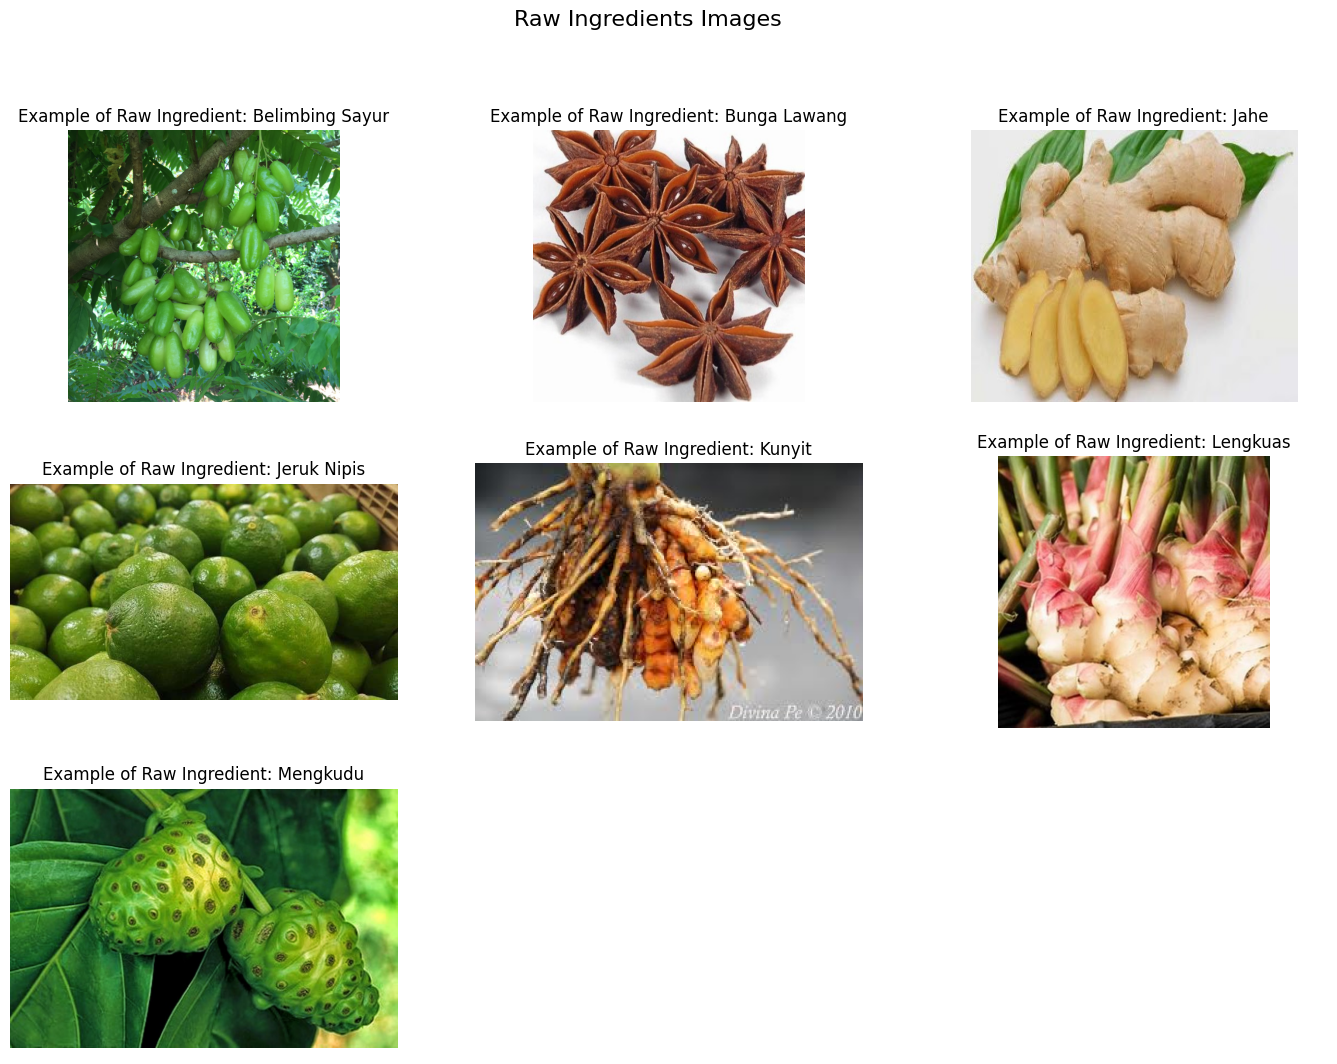

In [5]:
# Plot Raw Ingredient Images
fig, axes = plt.subplots(3, 3, figsize=(17, 12))
fig.suptitle('Raw Ingredients Images', fontsize=16)

# List of Ingredients
ingredients_list = ['Belimbing Sayur', 'Bunga Lawang', 'Jahe', 'Jeruk Nipis', 'Kunyit', 'Lengkuas', 'Mengkudu']

# Plot images for each ingredient
for ii, ingredient in enumerate(ingredients_list):
    dir_path = f'./Dataset/train/{ingredient}'
    img = tf.keras.preprocessing.image.load_img(dir_path + '/' + os.listdir(dir_path)[0])
    row, col = divmod(ii, 3)
    axes[row, col].imshow(img)
    axes[row, col].set_title(f'Example of Raw Ingredient: {ingredient}')
    axes[row, col].axis('off')

# Disable axis on empty subplots if any
for jj in range(len(ingredients_list), 9):
    row, col = divmod(jj, 3)
    axes[row, col].axis('off')

plt.show()

In [6]:
# Display Image Size
sample_array = tf.keras.preprocessing.image.img_to_array(img)
print(f"Each image has size: {sample_array.shape}")


Each image has size: (1069, 1600, 3)


In [7]:
# Buat model dengan EfficientNetV2-L
def create_efficientnetv2l_model(num_classes):
    # Load model EfficientNetV2-L tanpa lapisan atas (top layer)
    base_model = EfficientNetV2L(weights='imagenet', 
                                 include_top=False, 
                                 input_shape=(224, 224, 3))

    # Freeze semua layer di EfficientNetV2-L agar bobotnya tidak ikut dilatih
    base_model.trainable = False

    # Tambahkan layer tambahan setelah EfficientNetV2-L
    inputs = tf.keras.Input(shape=(224, 224, 3))
    x = base_model(inputs, training=False)
    x = Flatten()(x)
    x = Dense(512, activation='relu')(x)
    # x = Dropout(0.5)(x)
    outputs = Dense(num_classes, activation='softmax')(x)

    # Buat model akhir
    model = Model(inputs, outputs)

    # Kompilasi model
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

    return model

# Contoh pemakaian
num_classes = 7  # Ganti dengan jumlah kelas sesuai dataset Anda
model_efficientnet = create_efficientnetv2l_model(num_classes)
model_efficientnet.summary()

AttributeError: module 'ml_dtypes' has no attribute 'float8_e3m4'


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ efficientnetv2-l (Functional)   │ (None, 7, 7, 1280)     │   117,746,848 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 62720)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │    32,113,152 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 7)              │         3,591 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 149,863,591 (571.68 MB)

 Trainable params: 32,116,743 (122.52 MB)

 Non-trainable params: 117,746,848 (449.17 MB)

In [8]:
BATCH_SIZE = 16
IMAGE_SIZE = (224, 224)  # EfficientNetV2-L menggunakan resolusi 224x224
LABEL_MODE = 'categorical'
EPOCHS = 500


In [9]:
# Inisiasi Dataset
# Instantiate the training dataset
train_dataset = tf.keras.utils.image_dataset_from_directory(
    data_train,
    image_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    label_mode=LABEL_MODE
    )

# Instantiate the validation dataset
validation_dataset = tf.keras.utils.image_dataset_from_directory(
    data_validation,
    image_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    label_mode=LABEL_MODE
    )

Found 2055 files belonging to 7 classes.
Found 487 files belonging to 7 classes.


In [10]:
# Optimization
SHUFFLE_BUFFER_SIZE = 1000
PREFETCH_BUFFER_SIZE = tf.data.AUTOTUNE

train_dataset_final = (
    train_dataset
    .cache()
    .shuffle(SHUFFLE_BUFFER_SIZE)
    .prefetch(PREFETCH_BUFFER_SIZE)
)

validation_dataset_final = (
    validation_dataset
    .cache()
    .prefetch(PREFETCH_BUFFER_SIZE)
)

In [11]:
# Callbacks
class EarlyStoppingCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        train_accuracy = logs.get('accuracy')
        val_accuracy = logs.get('val_accuracy')

        if train_accuracy >= 0.95 and val_accuracy >= 0.85:
            self.model.stop_training = True
            print("\nReached 95% train accuracy and 85% validation accuracy, so cancelling training!")


In [12]:
# Training Constants
EPOCHS = 50

# Train the Model
history = model_efficientnet.fit(
    train_dataset_final,
    epochs=EPOCHS,
    verbose=1,
    validation_data=validation_dataset_final,
    callbacks=[EarlyStoppingCallback()]
)

Epoch 1/50



KeyboardInterrupt



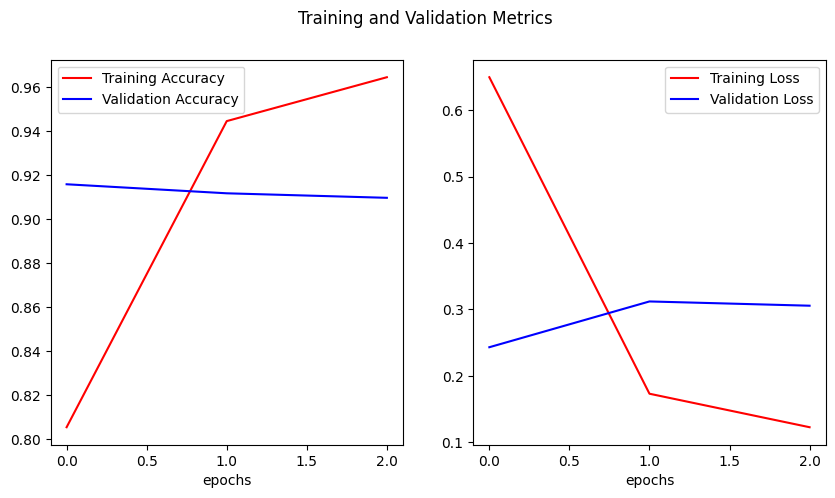

In [12]:
# Plot training and validation accuracy & loss
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

# Get number of epochs
epochs = range(len(acc))

fig, ax = plt.subplots(1, 2, figsize=(10, 5))
fig.suptitle('Training and Validation Metrics')

for i, (data, label) in enumerate(zip([(acc, val_acc), (loss, val_loss)], ["Accuracy", "Loss"])):
    ax[i].plot(epochs, data[0], 'r', label="Training " + label)
    ax[i].plot(epochs, data[1], 'b', label="Validation " + label)
    ax[i].legend()
    ax[i].set_xlabel('epochs')

plt.show()

31/31 ━━━━━━━━━━━━━━━━━━━━ 86s 3s/step


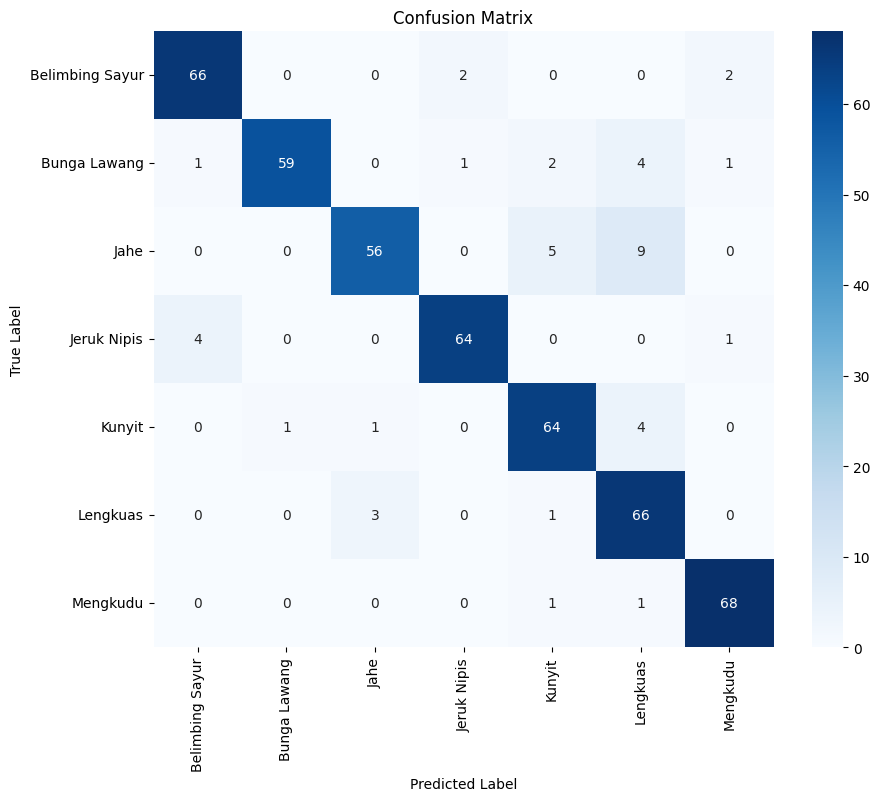

In [13]:
# Get true labels and predictions for the validation set
y_true = np.concatenate([y for x, y in validation_dataset_final], axis=0)
y_pred = model_efficientnet.predict(validation_dataset_final)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(y_true, axis=1)

# Create confusion matrix
conf_matrix = confusion_matrix(y_true_classes, y_pred_classes)

# Define function to plot confusion matrix
def plot_confusion_matrix(cm, class_names):
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.title('Confusion Matrix')
    plt.show()

# Plot the confusion matrix
class_names = ['Belimbing Sayur', 'Bunga Lawang', 'Jahe', 'Jeruk Nipis', 'Kunyit', 'Lengkuas', 'Mengkudu']  # Labels for ingredients
plot_confusion_matrix(conf_matrix, class_names)

Augmentation

In [13]:
FILL_MODE='nearest'
# Membuat layer augmentasi data
data_augmentation = tf.keras.Sequential([
    tf.keras.Input(shape=(224, 224, 3)),
    RandomFlip("horizontal"),# Membalik gambar secara horizontal
    RandomRotation(0.2, fill_mode=FILL_MODE), # Rotasi gambar hingga 20%
    RandomZoom(0.2, fill_mode=FILL_MODE),  # Zoom gambar hingga 20%
    RandomContrast(0.2), # Mengubah kontras gambar hingga 20%
    RandomTranslation(0.1, 0.1, fill_mode=FILL_MODE) # Translasi (geser) gambar hingga 10% horizontal dan vertikal
])

In [14]:
def demo_augmentation(sample_image, model, NUM_AUG):
    '''Takes a single image array, then uses a model to generate num_aug transformations'''

    # Instantiate preview list
    #simapan gambar asli dan hasil aumgmentasi 
    #biar bisa dilihat perbanndingannya
    image_preview = []

    # Convert input image to a PIL image instance
    # mengubah array gambar menjadi objek gambar PIL
    sample_image_pil = tf.keras.utils.array_to_img(sample_image)

    # Append the result to the list
    image_preview.append(sample_image_pil)

    # Apply the image augmentation and append the results to the list
    for i in range(NUM_AUG): #dilakukan augmentasi num_aug kali
        # Menambahkan dimensi ekstra pada gambar agar sesuai dengan input model augmentasi.
        sample_image_aug = model(tf.expand_dims(sample_image, axis=0))
        #gambar di convert ke PIL
        sample_image_aug_pil = tf.keras.utils.array_to_img(tf.squeeze(sample_image_aug))
        image_preview.append(sample_image_aug_pil)

    # Instantiate a subplot
    fig, axes = plt.subplots(1, NUM_AUG + 1, figsize=(12, 12))

    # Preview the images.
    for index, ax in enumerate(axes):
        ax.imshow(image_preview[index])
        ax.set_axis_off()

        if index == 0:
            ax.set_title('original')
        else:
            ax.set_title(f'augment {index}')

In [15]:
# Get a batch of images untuk lihat beberapa gambar yang bisa di augmentasikan
sample_batch = list(train_dataset.take(1))[0][0]
print(f'images per batch: {len(sample_batch)}')

images per batch: 16


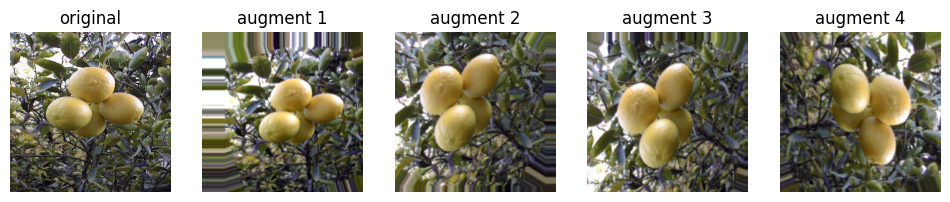

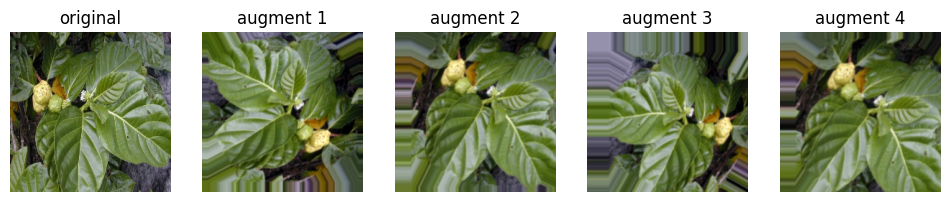

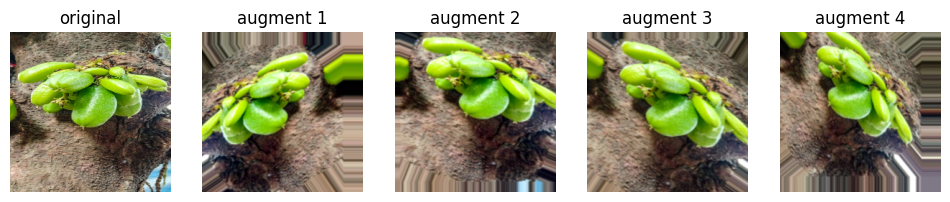

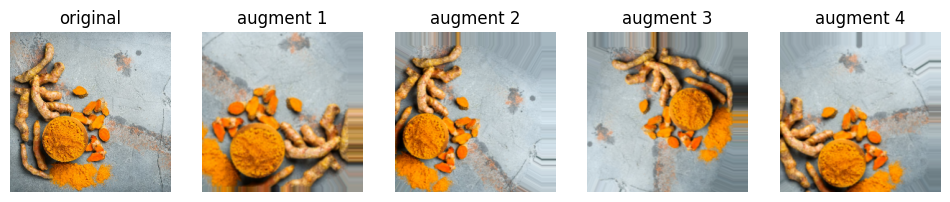

In [16]:
NUM_AUG = 4

# Apply the transformations to the first 4 images
demo_augmentation(sample_batch[0], data_augmentation, NUM_AUG)
demo_augmentation(sample_batch[1], data_augmentation, NUM_AUG)
demo_augmentation(sample_batch[2], data_augmentation, NUM_AUG)
demo_augmentation(sample_batch[3], data_augmentation, NUM_AUG)


# Uncomment the line below to delete the variable to free up some memory
# del sample_batch

In [19]:
# Fungsi untuk membuat model EfficientNetV2-L dengan layer tambahan
def create_efficientnetv2l_model_aug(num_classes):
    # Load model EfficientNetV2-L tanpa lapisan atas (top layer)
    base_model = EfficientNetV2L(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

    # Freeze semua layer di EfficientNetV2-L agar bobotnya tidak ikut dilatih
    base_model.trainable = False

    # Tambahkan layer tambahan setelah EfficientNetV2-L
    inputs = tf.keras.Input(shape=(224, 224, 3))
    x = data_augmentation(inputs)  # Terapkan augmentasi data
    x = base_model(x, training=False)  # Sambungkan augmentasi ke base model
    x = Flatten()(x)
    x = Dense(512, activation='relu')(x)
    # x = Dropout(0.5)(x)
    outputs = Dense(num_classes, activation='softmax')(x)

    # Buat model akhir
    model = Model(inputs, outputs)

    # Kompilasi model
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

    return model

In [20]:
# Membuat model
num_classes = 7  # Ganti dengan jumlah kelas sesuai dataset Anda
model_efficientnet_aug = create_efficientnetv2l_model_aug(num_classes)
model_efficientnet_aug.summary()

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_6 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential (Sequential)         │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ efficientnetv2-l (Functional)   │ (None, 7, 7, 1280)     │   117,746,848 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 62720)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 512)            │    32,113,152 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 7)              │         3,591 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 149,863,591 (571.68 MB)

 Trainable params: 32,116,743 (122.52 MB)

 Non-trainable params: 117,746,848 (449.17 MB)

In [20]:
# Training model dengan data augmentasi
history = model_efficientnet_aug.fit(
    train_dataset_final,
    epochs=EPOCHS,
    verbose=1,
    validation_data=validation_dataset_final,
    callbacks=[EarlyStoppingCallback()]
)


Epoch 1/50
129/129 ━━━━━━━━━━━━━━━━━━━━ 487s 3s/step - accuracy: 0.7077 - loss: 1.0325 - val_accuracy: 0.9076 - val_loss: 0.2873
Epoch 2/50
129/129 ━━━━━━━━━━━━━━━━━━━━ 464s 4s/step - accuracy: 0.8517 - loss: 0.4218 - val_accuracy: 0.8830 - val_loss: 0.3445
Epoch 3/50
129/129 ━━━━━━━━━━━━━━━━━━━━ 439s 3s/step - accuracy: 0.8833 - loss: 0.3306 - val_accuracy: 0.9179 - val_loss: 0.3126
Epoch 4/50
129/129 ━━━━━━━━━━━━━━━━━━━━ 508s 4s/step - accuracy: 0.9034 - loss: 0.2685 - val_accuracy: 0.9220 - val_loss: 0.2723
Epoch 5/50
129/129 ━━━━━━━━━━━━━━━━━━━━ 488s 4s/step - accuracy: 0.9199 - loss: 0.2805 - val_accuracy: 0.9322 - val_loss: 0.2687
Epoch 6/50
129/129 ━━━━━━━━━━━━━━━━━━━━ 442s 3s/step - accuracy: 0.9204 - loss: 0.2150 - val_accuracy: 0.9322 - val_loss: 0.2344
Epoch 7/50
129/129 ━━━━━━━━━━━━━━━━━━━━ 414s 3s/step - accuracy: 0.9295 - loss: 0.1954 - val_accuracy: 0.9384 - val_loss: 0.2752
Epoch 8/50
129/129 ━━━━━━━━━━━━━━━━━━━━ 408s 3s/step - accuracy: 0.9347 - loss: 0.2088 - val_accu

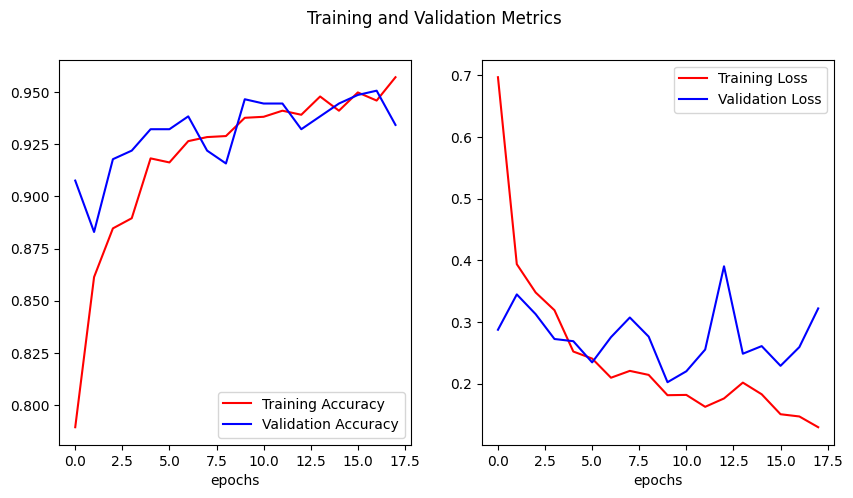

In [21]:
# Plot training and validation accuracy & loss
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

# Get number of epochs
epochs = range(len(acc))

fig, ax = plt.subplots(1, 2, figsize=(10, 5))
fig.suptitle('Training and Validation Metrics')

for i, (data, label) in enumerate(zip([(acc, val_acc), (loss, val_loss)], ["Accuracy", "Loss"])):
    ax[i].plot(epochs, data[0], 'r', label="Training " + label)
    ax[i].plot(epochs, data[1], 'b', label="Validation " + label)
    ax[i].legend()
    ax[i].set_xlabel('epochs')

plt.show()

31/31 ━━━━━━━━━━━━━━━━━━━━ 95s 3s/step


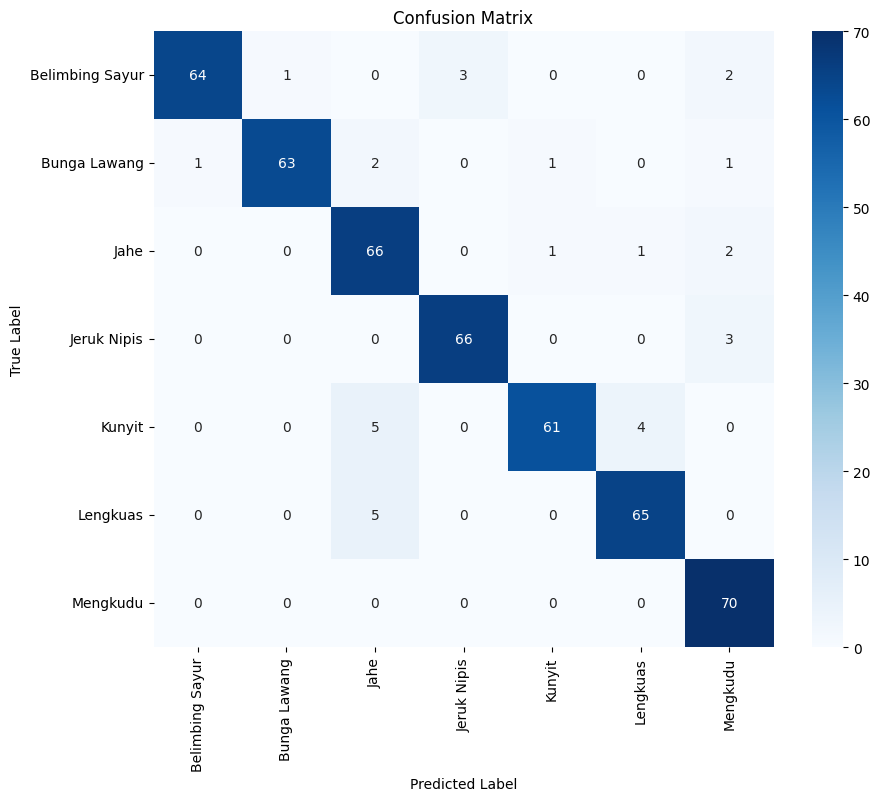

In [22]:
# Get true labels and predictions for the validation set
y_true = np.concatenate([y for x, y in validation_dataset_final], axis=0)
y_pred = model_efficientnet_aug.predict(validation_dataset_final)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(y_true, axis=1)

# Create confusion matrix
conf_matrix = confusion_matrix(y_true_classes, y_pred_classes)

# Define function to plot confusion matrix
def plot_confusion_matrix(cm, class_names):
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.title('Confusion Matrix')
    plt.show()

# Plot the confusion matrix
class_names = ['Belimbing Sayur', 'Bunga Lawang', 'Jahe', 'Jeruk Nipis', 'Kunyit', 'Lengkuas', 'Mengkudu']  # Labels for ingredients
plot_confusion_matrix(conf_matrix, class_names)